# MAPD-B distributed processing exam: Analysis of Covid-19 papers

## Part 3: The embedding for the title of the papers 

Student: Nguyen Xuan Tung

ID: 2005491

##### Library

In [1]:
#pip install fasttext                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
from collections import Counter
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask import delayed
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pathlib import Path
from gensim.models import KeyedVectors
from tqdm import tqdm

import matplotlib.pyplot as plt
import dask.bag as db
import numpy as np
import pandas as pd
import seaborn as sns
import dask
import time
import json
import os
import re
import nltk
import sys
import re
import time
import warnings
import nltk
 
from gensim.models.fasttext import FastText
import gensim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize import WhitespaceTokenizer

 

#### Create cluster

Check the client and cores. In this case, we have 2 workers are created, each with 1 core corresponding

In [2]:
client = Client()
client

/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41623 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:46839 Dashboard: http://127.0.0.1:41623/status,Cluster Workers: 2 Cores: 2 Memory: 5.28 GB


In [3]:
print("Python Version : ", sys.version)
print("Dask Version : ", dask.__version__)

Python Version :  3.6.13 | packaged by conda-forge | (default, Sep 23 2021, 07:56:31) 
[GCC 9.4.0]
Dask Version :  2021.03.0


#### Implement


In NLP a common technique to perform analysis over a set of texts is to transform the
text to a set of vectors each one representing a word inside a document. At the end of
the pre-processing the document will be transformed into a list of vectors or a matrix of
$n \times m$ where $n$ is the number of words in the document and $m$ is the size of the vector
that represents the word $n$.

More information about word-embedding: https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
What you can do is to transform the title of the paper into its embedding version by using
the pre-trained model available on FastText page: https://fasttext.cc/docs/en/pretrained-vectors.html.
The pre-trained model that you have to download is the https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
Basically the pre-trained model is more or less a huge dictionary in the following format
$key : vector$.

To load the model follow this snippet of code which is slightly different from what you
can find at this page https://fasttext.cc/docs/en/english-vectors.html

In this task, we will: 


 - Load the data plucking only the metadata field of each paper, since it contains the title
 
 
 - load the english fasttext model
 
 
 - create one dictionary per paper, each one with its title and the embedding for it
 
 
 - save each dictionary in a .json file
 

Read paper from JSON file

Since the original folder contain too many files (over 20000 files), we made a new folder contains fewer files (2162 files)

In [4]:
path_to_json = 'Covid19_data/document_parses/preprocessed/'

files = [path_to_json+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

path_to_one_line_json='Covid19_data/document_parses/preprocessed_1'

for i in range(len(files)):
    f = open(files[i],"r")
    f_one_line = open(path_to_one_line_json+str(i)+".json","w+")
    s = f.read()
    s = s.replace('\t','')
    s = s.replace('\n','')
    s = s.replace(" ","")
    
    f_one_line.write( str( re.split("[\n]", s )[0] ) )


f_one_line.close()
f.close() 

Load the files

We use dask bag to read ad process the json data. since the format of json data does not really enforce strict structure and data types, bag objects can be seen as the pythonic version of PySpark RDDs. They hold the standard functional API like map, filter, groupby, etc..

In [5]:
filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(20) 

Running the model

In [6]:
start=time.time()

word_vectors = KeyedVectors.load_word2vec_format('wiki.en.vec')
stop=time.time()

print("time to run model:",stop-start, "secs")

time to run model: 1906.0438656806946 secs


In [7]:
word_vectors['collection']

array([ 0.16487   , -0.37781   ,  0.10165   , -0.058655  ,  0.1567    ,
        0.55286   ,  0.2192    , -0.24161   ,  0.056417  ,  0.12307   ,
       -0.0021497 ,  0.3103    ,  0.034216  ,  0.0010884 , -0.43839   ,
       -0.42546   ,  0.31738   ,  0.29642   ,  0.16258   ,  0.11507   ,
       -0.048637  ,  0.13901   , -0.43144   ,  0.056601  ,  0.20591   ,
        0.12192   , -0.33687   ,  0.11246   ,  0.46472   , -0.063465  ,
       -0.29672   ,  0.39157   ,  0.069056  ,  0.19399   ,  0.34861   ,
       -0.21041   ,  0.071331  , -0.34916   , -0.043387  ,  0.08798   ,
        0.30783   , -0.21371   ,  0.01475   ,  0.040059  , -0.40749   ,
       -0.20512   , -0.027903  , -0.5183    ,  0.17494   ,  0.029446  ,
       -0.10412   , -0.069918  ,  0.15337   ,  0.12599   , -0.1029    ,
       -0.031872  ,  0.050948  , -0.073986  , -0.35038   ,  0.42087   ,
        0.070592  ,  0.055298  , -0.085695  ,  0.042058  , -0.058535  ,
        0.0089174 , -0.15605   , -0.11077   ,  0.012593  , -0.09

In order to create a BAG composed by:

- paper-id
- title-embedding

we create the function flatten(record) which will return the paper_id and title of all the articles and make use of the map function provided by Dask Bag. We also apply a filter in order to remove all the empty title.

In [8]:
def flatten(record):
    return {
        "paper_id": record['paper_id'],
        "title": record['metadata']['title']
            }


In [9]:
data = js.map(flatten).filter(lambda record: bool(record['title'])).compute()

In [10]:
data

[{'paper_id': '0000b6da665726420ab8ac9246d526f2f44d5943',
  'title': 'The cell phone vibration test: A telemedicine substitute for the tuning fork test'},
 {'paper_id': '0000b93c66f991236db92dc16fa6db119b27ca12',
  'title': 'Infections in Hematopoietic Stem Cell Transplantation (HSCT) Patients 24'},
 {'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title': 'PfSWIB, a potential chromatin regulator for var gene regulation and parasite development in Plasmodium falciparum'},
 {'paper_id': '000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a',
  'title': 'Correlation between antimicrobial consumption and incidence of health-care- associated infections due to methicillin- resistant Staphylococcus aureus and vancomycin-resistant enterococci at a university hospital in Taiwan from 2000 to 2010'},
 {'paper_id': '000b0174f992cb326a891f756d4ae5531f2845f7',
  'title': 'Full Title: A systematic review of MERS-CoV (Middle East Respiratory Syndrome Coronavirus) 2 seroprevalence and viral RNA prevale



Now we make use of the pre-trained model and create two functions:

   - `create_dict(dict, model)`: which creates a dictionary consist of the paper_id and the embedding title.
   

   - `embedded(text, wiki)`: which takes the text of the title as input, lower case it (in the sense of converting all capital letter to small letter) and split it. Then apply the pre-trained model and convert each word into an np.array().

It should be notice that lowering the text was necesary since the 'wiki.en.vec' model is not able to detect Capital Letters. On the other hand, not all the words of the title were converted due to not being in the model.


In [11]:
def create_dict(record, model):
    return{
        "paper_id": record["paper_id"],
        "title": embedder(record['title'], model)
    }


In [12]:
def embedder(text, wiki):
    text_split = text.lower().split() # we lower case all the words of the title to get a proper cosine similarity
    words_embedded=[]

    for words in text_split:
        try:
            words_embedded.append( wiki[words])
        except:
            pass  #some of the words weren't on the model because they were to scientific.
   
    return words_embedded

In [13]:
titles_embedded = [create_dict(datos,  word_vectors) for datos in data]

In [14]:
titles = db.from_sequence(titles_embedded)

In [15]:
titles.take(1)

({'paper_id': '0000b6da665726420ab8ac9246d526f2f44d5943',
  'title': [array([-0.065334 , -0.093031 , -0.017571 ,  0.20007  ,  0.029521 ,
          -0.03992  , -0.16328  , -0.072946 ,  0.089604 ,  0.080907 ,
          -0.040032 , -0.23624  ,  0.1825   , -0.061241 , -0.064386 ,
          -0.075258 , -0.050076 , -0.020001 ,  0.003496 ,  0.14487  ,
          -0.16791  ,  0.076852 , -0.22977  , -0.057937 , -0.13408  ,
          -0.073586 , -0.0012575,  0.019708 ,  0.056866 ,  0.0625   ,
          -0.15555  ,  0.15207  , -0.10629  ,  0.2467   , -0.027853 ,
          -0.17703  ,  0.0072058, -0.11941  ,  0.083843 , -0.11843  ,
           0.053612 , -0.0023144, -0.084279 ,  0.02842  ,  0.078184 ,
          -0.12017  , -0.040866 ,  0.089438 ,  0.050845 , -0.06372  ,
           0.070864 , -0.063962 , -0.095329 ,  0.069848 , -0.050254 ,
           0.058265 ,  0.085877 ,  0.043966 , -0.051179 ,  0.097819 ,
          -0.050705 , -0.18195  ,  0.32365  , -0.076363 ,  0.046492 ,
          -0.19886  , -

### Bonus point

We will now make used of the previously generated vectors to compute the cosine similarity between each paper and to figure out a couple of papers with the highest cosine similarity score.

We first begin by defining the `cosine_similarity`function which basically computes the similarity between the texts as shown in the image.

We compute the similarity word by word among the texts. When one of the text end, there's no more comparision.

The function `similarity` computes the similarity among two different sentence and return a dictionary. Finally we construct a similarity matrix.

In [16]:
def cosine_similarity(vec1, vec2):

    norm_vec1 = np.linalg.norm(vec1)   
    norm_vec2 =  np.linalg.norm(vec2)
    
    m = min(len(vec1), len(vec2)) # min of the length of either of two vectors is taken to compute inner product
    result = np.vdot(vec1[:m], vec2[:m])/(norm_vec1*norm_vec2)
    return result


def similarity(vec1, vec2):
    
    val = cosine_similarity(vec1['title'], vec2['title'])
    
    return{
        'paper 1': vec1['paper_id'],
        'paper 2' : vec2['paper_id'],
        'similarity' : val}

# Constructing a similarity matrix
dim = len(titles_embedded) # dimension of the matrix
sim_matrix = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        vec_i = titles_embedded[i]
        vec_j = titles_embedded[j]
        sim_matrix[i][j] = similarity(vec_i,vec_j)['similarity']



/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Visualizing similarity for first 50 papers

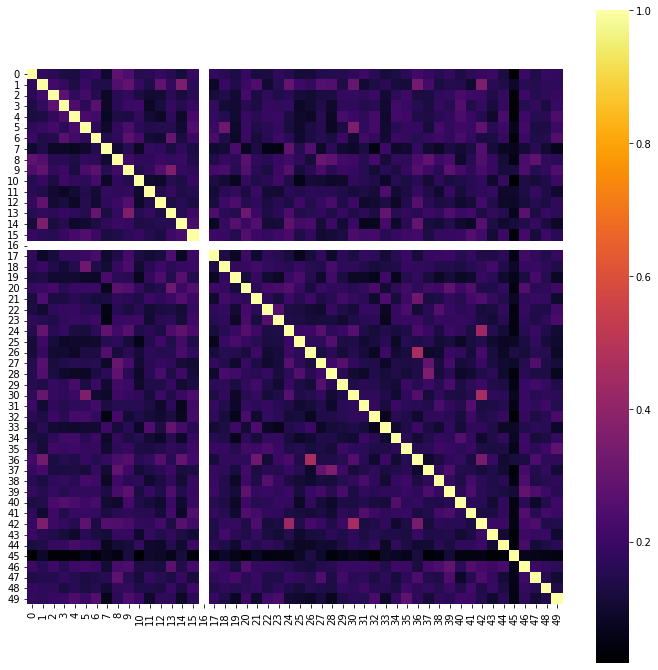

In [17]:
plt.figure(figsize=(12,12))

#ax = sns.heatmap(sim_matrix, vmin=-1, vmax=1, center=0, square=True)
sns.heatmap(sim_matrix[:50,:50], cmap="inferno",square=True)
#sns.heatmap(sim_matrix,cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.show()

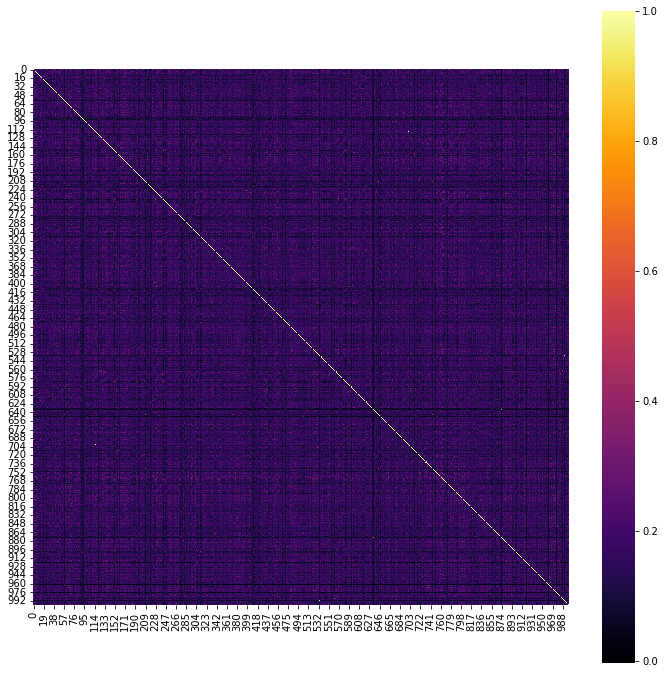

In [20]:
plt.figure(figsize=(12,12))

#ax = sns.heatmap(sim_matrix, vmin=-1, vmax=1, center=0, square=True)
sns.heatmap(sim_matrix[:1000,:1000], cmap="inferno",square=True)
#sns.heatmap(sim_matrix,cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.show()

In [18]:
print(data[26])
print(data[36])

print("Cosine_simialrity Metric:",sim_matrix[26,36])

{'paper_id': '000ee7a319f964af24836e5b0402cc7576edff6d', 'title': 'Journal of Adolescent Health xxx (2020) 1e2 Letter'}
{'paper_id': '00a1f7fe456852517e74e626e942d79978164270', 'title': '0123456789) 1 3 Journal of Clinical Psychology in Medical Settings'}
Cosine_simialrity Metric: 0.46113282442092896


In [19]:
print(data[30])
print(data[42])

print("Cosine_simialrity Metric:",sim_matrix[30,42])

{'paper_id': '00a0ab182dc01b6c2e737dfae585f050dcf9a7a5', 'title': 'Middle East respiratory syndrome: An emerging coronavirus infection tracked by the crowd'}
{'paper_id': '00a3a4742c565f5e2e64ad03fe0f1e16baee89b3', 'title': 'Plethora of Respiratory Viruses and Respiratory Virus Data'}
Cosine_simialrity Metric: 0.45777037739753723
